In [1]:
### Defining Environment variables pointing to user folders
from os import environ, path, makedirs
from json import load
import yaml

environ.setdefault('HOME_DIR', "/mlinfn/shared/lamarr/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/j100")
environ.setdefault('MODEL_STORAGE',environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault("MODEL_VARIANT","")
environ.setdefault('FEATHER_FOLDER' ,environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER'])

# load configuration file containing different training folders of different models
with open(environ.get('CONFIG_FILE','configs/test_config.yaml'), 'r') as file:
    ext_config = yaml.safe_load(file)
    for m,train_keys in ext_config['deploy_models'].items():
        for tk in train_keys: # check the model should be deployed for this train key
            if ext_config['training_folder'][tk] == environ['TRAINING_DATA_FOLDER']:
                environ.setdefault(f'{m.upper()}_MODEL',environ['MODEL_STORAGE']+f"/models/{m}/saved_model.pb")
                environ.setdefault(f"{m.upper()}_TEST_DATA", environ['FEATHER_FOLDER']+f"/{m}-validation")

#environ.setdefault('ACCEPTANCE_MODEL',environ['MODEL_STORAGE']+"/models/acceptance/saved_model.pb")
#environ.setdefault('EFFICIENCY_MODEL',environ['MODEL_STORAGE']+"/models/efficiency/saved_model.pb")
#environ.setdefault('RESOLUTION_MODEL',environ['MODEL_STORAGE']+"/models/resolution/saved_model.pb")
#environ.setdefault('COVARIANCE_MODEL',environ['MODEL_STORAGE']+"/models/covariance/saved_model.pb")
environ.setdefault('GENERATED_C_FILE',"exported"+environ['TRAINING_DATA_FOLDER']+"/generated.C")

#if environ['MODEL_VARIANT'] != '':
#    for model in ["acceptance","efficiency","resolution","covariance"]:
#        model_path,model_name = path.split(environ[f'{model.upper()}_MODEL'])
#        environ[f'{model.upper()}_MODEL'] = path.join(model_path,environ['MODEL_VARIANT'], model_name)
#    Cfile_path,Cfile_name = path.split(environ['GENERATED_C_FILE'])
#    environ['GENERATED_C_FILE']  = path.join(Cfile_path,environ['MODEL_VARIANT'], Cfile_name)

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

# Deployment as a C-compiled shared library

In order to run the trained parametrizations within a Gaudi application,
some transformation to a format that can be easily loaded from C/C++.
Several options were considered, but most of them require a dedicated runtime
to be deployed and linked in the target application.

In practice, the runtimes are extremely effective to distribute the
computation on multiple cores and are designed to speed up the evaluation
of the networks on large batches of data samples.
Unfortunately, in Lamarr the number of particles we can process per
event is rather limited and the complexity of the models is also not
comparable to those used for Computer Vision or Natural Language Processing
tasks. As a consequence, the overhead introduced for context switching
when passing the input variables to the main thread to the
runtime thread is unacceptable large.
In addition, the latest versions of Gaudi introduce multithread
processing that ease to reduce the memory footprint of the applications.
Unfortunately, the schedulers designed for runtime use a completly different
logic from the Gaudi scheduler and are cerainly not designed to interact
effectively with Gaudi. In conclusion, the attempts of relying on the
TensorFlow C++ APIs and a first exploration of using ONNX for Lamarr,
convinced the Simulation Project to move towards other alternatives.

A totally different approach, developed in the context of real time
processing for plasma control in nuclear fusion experiments is to translate
the neural network in compatible C code, compile it, and link it
to the main application.
The most important effort in this direction lead to the release of
[keras2c](https://github.com/f0uriest/keras2c).

In LHCb, we have developed our own version of a transpiler of *scikit-learn*
and Keras models to compatible C code, under the name
[`scikinC`](https://github.com/landerlini/scikinC).
While much more limited in terms of support for neural networks, scikinC
provides functionalities to combine the preprocessing step with the model
in a very simple and clean way.

In this notebook we will run a development version of scikinC as some
of the functionalities needed to deploy these neural networks are being
implemented now.


In [2]:
## Installing a development version of scikinC directly from GitHub
#!conda run -n base pip install -q --upgrade  git+https://github.com/landerlini/scikinC.git@validation_helpers --force-reinstall --no-deps
## Importng scikinC
import scikinC

## Libraries and environment
The libraries used to import the model and the validate model and deployment
are the same as for the validation notebooks.

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

## Loading and collapsing the models
In this notebook we are going to load four different models for:
 * acceptance,
 * efficiency,
 * resolution,
 * covariance.

For each of these models, we are loading:
 * a preprocessing step (named `tX`)
 * a Deep Neural Network model

for the GAN models (resolution and covariance) we are loading a
*postprocessing* step (named `tY`) as well.
To handle the model loading and some manipulation needed to make it
ready to be deployed, we rely on a custom class, named `LamarrModel`
defined in the local module [`deploy_utils.py`](./deploy_utils.py).
The class `LamarrModel` takes as an input the path of a keras model,
and loads from the corresponding folder:
 * the Neural Network model
 * if a `tX.pkl` file is found, it loads it as a pickled preprocessing step
 * if a `tY.pkl` file is found, it loads it as a pickled postprocessing step

Then, it tries to convert the model to a keras Sequential model.
Note that most of the neural networks defined in this repository include
skip connections and are therefore defined with the Functional APIs.
As of today, models defined with the Functional APIs cannot be converted
with scikinC, hence, a conversion of each DNN to a Sequential model is
necessary.
Note that the restriction to the Sequential form is formal, as long as
we do not constrain the operations single layers may perform.

In the particular case of dense layers with skip connections, we can
define a new layer, named `DenseWithSkipConnection` that implements the
operation
$$
\vec h_{i+1} = \vec h_{i} + \sigma(\mathbf{A} \vec h_{i} + \vec b),
$$
where $\mathbf{A}$ and $\vec {b}$ represent the weights of the dense
layer and $\sigma(\cdot)$ the activation function.
A stack of `DenseWithSkipConnection` layers can reproduce exactly the
functionality of the original neural network while being represented as
a Sequential model.

To be completely honest, this simply moves the problem to `scikinC`
that has now to provide a C implementation for our custom
`DenseWithSkipConnection` layer.
Fortunately, this is extremely immediate to implement (though a bit *hacky*),
requiring only few lines of Python, placed in the
[`deploy_utils.py`](./deploy_utils.py) module.

So, in summary, we are defining:
 * a custom layer named `DenseWithSkipConnection` that will replace any combination
   of a keras Dense layer followed by a skip connection;
 * a custom scikinC implementation for `DenseWithSkipConnection` that implements
   this layer in C, reusing the C code for converting Dense layers as much as possible.

Most of this happens behind the scenes in the implementation of the `LamarrModel`
class.

In [4]:
from deploy_utils import LamarrModel, hacks

## Definition of a custom layer converter in scikinC
import scikinC.layers
scikinC.layers.DenseWithSkipConnection = hacks.scikinC_DenseWithSkipConnection

In [5]:
if "ACCEPTANCE_MODEL" in environ.keys():
    acceptance = LamarrModel.from_saved_model_pb(
        environ.get("ACCEPTANCE_MODEL",  f"/mlinfn/shared/lamarr/{environ['USERNAME']}/trained_models{environ['TRAINING_DATA_FOLDER']}/models/acceptance/saved_model.pb")
    )

Loading model from '/mlinfn/shared/lamarr/scapelli/trained_models/j100/models/acceptance'.  Preprocessing: 👌.Postprocessing: 😞.
Check on the number of weights: ✅! Original model: 84353. Collapsed model: 84353. 


In [6]:
if "EFFICIENCY_MODEL" in environ.keys():
    efficiency = LamarrModel.from_saved_model_pb(
    environ.get("EFFICIENCY_MODEL",  f"/mlinfn/shared/lamarr/{environ['USERNAME']}/trained_models{environ['TRAINING_DATA_FOLDER']}/models/efficiency/saved_model.pb")
    )

Loading model from '/mlinfn/shared/lamarr/scapelli/trained_models/j100/models/efficiency'.  Preprocessing: 👌.Postprocessing: 😞.
Check on the number of weights: ✅! Original model: 84740. Collapsed model: 84740. 


In [7]:
if "RESOLUTION_MODEL" in environ.keys():
    resolution = LamarrModel.from_saved_model_pb(
        environ.get("RESOLUTION_MODEL",  f"/mlinfn/shared/lamarr/{environ['USERNAME']}/trained_models{environ['TRAINING_DATA_FOLDER']}/models/resolution/saved_model.pb")
    )

Loading model from '/mlinfn/shared/lamarr/scapelli/trained_models/j100/models/resolution'.  Preprocessing: 👌.Postprocessing: 👌.
Check on the number of weights: ✅! Original model: 184329. Collapsed model: 184329. 


In [8]:
if "COVARIANCE_MODEL" in environ.keys():
    covariance = LamarrModel.from_saved_model_pb(
        environ.get("COVARIANCE_MODEL",  f"/mlinfn/shared/lamarr/{environ['USERNAME']}/trained_models{environ['TRAINING_DATA_FOLDER']}/models/covariance/saved_model.pb")
    )

/envs/root/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from '/mlinfn/shared/lamarr/scapelli/trained_models/j100/models/covariance'.  Preprocessing: 👌.Postprocessing: 👌.
Check on the number of weights: ✅! Original model: 152463. Collapsed model: 152463. 


## Exporting the models to a shared object

In order to export the models to a shared object we have to obtain
a C code describing the models and then to compile the C code.
For all operations supported by scikinC, we rely on code generation.
For GANs, we will need to glue some steps together with custom C functions.

### Generation of C code

For models like acceptance and efficiency where all the transform and the evaluations are pipelined in the same "*direction*" as they were trained, we can define *scikit-learn* Pipelines with the sequence of transformations and models and let scikinC to generate the glue between the preprocessing and DNN steps.

For GANs this is not possible because we cannot pipeline the inverse of the postprocessing transformation `tY`.
Besides, the input features have to be preprocessed, but the random noise should be injected directly in the generator model,
breaking the Pipeline model.
Hence, we generate C code for each step (preprocessing, model and postprocessing) separately.


> Note. In addition, `scikinC` does not support pipelines of pipelines and the covariance GAN preprocessing step is defined as a pipeline, so even defining a inverse QuantileTransformer and injecting it in the pipeline would not be sufficient to automate the generation of the complete C code.



In [9]:
there_is_GAN = False # flag to check if there are GAN moels to be

models = dict()
if "ACCEPTANCE_MODEL" in environ.keys():# Acceptance model
    models['acceptance'] = acceptance.pipeline
    
if "EFFICIENCY_MODEL" in environ.keys():# Efficiency model
    models['efficiency'] = efficiency.pipeline
    
if "RESOLUTION_MODEL" in environ.keys():# Resolution model
    there_is_GAN = True
    models['resolution_tX'] = resolution.tX
    models['resolution_tY'] = resolution.tY
    models['resolution_dnn'] = resolution.collapsed_model
    
    res_in = resolution.tX.n_features_in_
    res_out = resolution.tY.n_features_in_
    res_rnd = resolution.model.input_shape[1][1]
    
if "COVARIANCE_MODEL" in environ.keys(): # Covariance model
    there_is_GAN = True
    models['covariance_tX'] = covariance.tX
    models['covariance_tY'] = covariance.tY
    models['covariance_dnn'] = covariance.collapsed_model
    
    cov_in = covariance.tX.n_features_in_
    cov_out = covariance.tY.n_features_in_
    cov_rnd = covariance.model.input_shape[1][1]
    
# Retrieve the name of the file from the environment
generated_c = environ.get("GENERATED_C_FILE", f"exported{environ['TRAINING_DATA_FOLDER']}/generated.C")
if not os.path.isdir(os.path.dirname(generated_c)): os.makedirs(os.path.dirname(generated_c))

# Runs the scikinC code generator and save the output in the generated_c file
print(scikinC.convert(models), file=open(generated_c, 'w'))

### Custom GAN pipelines

The pipelines for the resolution and covariance models are defined in a separate file (gan_pipeline.c),
reproduced below for completeness.

> Note that scikinC operates with a separate call for each row or array, so all the arrays are 1D.

In order to customize the pipeline with specific information from the model, such as 
the number of input and output features, or the dimensionality of the random noise,
we use symbols that will be defined at compile time. 

In [10]:
from IPython.display import Markdown
display(Markdown(f"```c\n{open('gan_pipelines.c').read()}\n```"))

```c
#define FLOAT_T float

/**** Prototypes of functions automatically generated by scikinC ****/
// Resolution steps
FLOAT_T* resolution_tX         (FLOAT_T*, const FLOAT_T*);
FLOAT_T* resolution_tY_inverse (FLOAT_T*, const FLOAT_T*);
FLOAT_T* resolution_dnn        (FLOAT_T*, const FLOAT_T*);

// Covariance steps
FLOAT_T* covariance_tX         (FLOAT_T*, const FLOAT_T*);
FLOAT_T* covariance_tY_inverse (FLOAT_T*, const FLOAT_T*);
FLOAT_T* covariance_dnn        (FLOAT_T*, const FLOAT_T*);


/**** Additional functions wrapping generated functions together ****/

// Resolution entry point
FLOAT_T* resolution (FLOAT_T* output, const FLOAT_T* input, const FLOAT_T* random)
{
    // Rename constants defined at compile time 
    const int nInputs = RESOLUTION_NUM_FEATURES;
    const int nOutputs = RESOLUTION_NUM_OUTPUTS;
    const int nRandom = RESOLUTION_NUM_RANDOM;

    // Instanciate variables in the stack.
    FLOAT_T buf[nInputs + nOutputs + nRandom];
    int i;
    
    // Preprocessing
    resolution_tX(buf, input);
    
    // Concatenate preprocessed features and random noise
    for (i = 0; i < nRandom; ++i)
        buf[i + nInputs] = random[i];
    
    // Execute the generator
    resolution_dnn(buf, buf);
    
    // Apply the inverse postprocessing transformation
    resolution_tY_inverse(output, buf);
    
    return output;
}

// Covariance entry point
FLOAT_T* covariance (FLOAT_T* output, const FLOAT_T* input, const FLOAT_T* random)
{
    // Rename constants defined at compile time 
    const int nInputs = COVARIANCE_NUM_FEATURES;
    const int nOutputs = COVARIANCE_NUM_OUTPUTS;
    const int nRandom = COVARIANCE_NUM_RANDOM;
    
    // Instanciate variables in the stack.
    FLOAT_T buf[nInputs + nOutputs + nRandom];
    int i;
    
    // Preprocessing
    covariance_tX(buf, input);
    
    // Concatenate preprcessed features and random noise
    for (i = 0; i < nRandom; ++i)
        buf[i + nInputs] = random[i];
    
    // Execute the DNN
    covariance_dnn(buf, buf);
    
    // Apply the inverse postprocessing transformation
    covariance_tY_inverse(output, buf);
    
    return output;
}
```

### Compilation to a shared object

To compile the code we simply retrieve the missing information from the loaded models and we call gcc.

The following compiler flags are worth a comment:
 * `-O3` defines a very high level of code optimization that may slighly reduce the floating point precision and 
   removes several checks on memory usage and allocation. For debugging, it should definitely be removed.
 * `-lm` links to the Standard C library with mathematic operations (as defined in the `math.h` header) and is needed for 
   the `tanh`, `log` and `exp` functions  used for activations
 * `--shared -fPIC` define the target binary as a shared library (instead of a static object or an executable application) to ease 
   importing the models in Gaudi at runtime.
   

The complete compile command is reported below.

In [11]:
default_lib_path = generated_c.replace('.C', str(np.random.randint(0xFFFFFF)) + '.so')
lib_path = environ.get("GENERATED_LIBRARY", default_lib_path)

if there_is_GAN:
    import subprocess
    cmd = [
        "gcc",
        generated_c,
        "gan_pipelines.c"]
    if "resolution_dnn" in models.keys():
        cmd += [
        f"-D RESOLUTION_NUM_FEATURES={res_in}",
        f"-D RESOLUTION_NUM_OUTPUTS={res_out}",
        f"-D RESOLUTION_NUM_RANDOM={res_rnd}"]
    if "covariance_dnn" in models.keys():
        cmd += [
        f"-D COVARIANCE_NUM_FEATURES={cov_in}",
        f"-D COVARIANCE_NUM_OUTPUTS={cov_out}",
        f"-D COVARIANCE_NUM_RANDOM={cov_rnd}"]
    cmd += [
        f"-o ./{lib_path}",
        "-O3", "-lm", "--shared", "-fPIC"]
    
    print ("Compilation command:\n", "  \\\n  ".join(cmd))
    print(os.system(" ".join(cmd)))

Compilation command:
 gcc  \
  exported/j100/generated.C  \
  gan_pipelines.c  \
  -D RESOLUTION_NUM_FEATURES=12  \
  -D RESOLUTION_NUM_OUTPUTS=9  \
  -D RESOLUTION_NUM_RANDOM=128  \
  -D COVARIANCE_NUM_FEATURES=15  \
  -D COVARIANCE_NUM_OUTPUTS=15  \
  -D COVARIANCE_NUM_RANDOM=128  \
  -o generated6316145.so  \
  -O3  \
  -lm  \
  --shared  \
  -fPIC
0


## Validation of the deployed models

To ensure that the converted models are reasonably good we should validate them by comparing their output to the original models.
Note in particular that they underwent two transformations:
 * they were collapsed from functional to sequential form
 * they were transpiled to C and compiled
 
The scikinC package provides a helper class named `MLFunction` to wrap a function in a compiled C library and evaluate it on numpy arrays.
A simple extension is need to also wrap our custom GAN pipelines which require passing random features as well. 
We will name such an extension `GanFunction`.


In [15]:
from scikinC.validation import MLFunction

class GanFunction (MLFunction):
    def __init__(self, lib_path, function_name, n_outputs, float_type=np.float32):
        MLFunction.__init__(self, lib_path, function_name, n_outputs, float_type=np.float32)
        # Define the C type of the arguments as C float (or numpy float32).
        self._f.argtypes = [np.ctypeslib.ndpointer(dtype=np.float32) for _ in (1, 2, 3)]
        
    def __call__ (self, data_in, data_rnd):
        # Define a buffer to store the output according to the size of the output array
        obuf = np.empty(self.n_outputs, dtype=np.float32)
        
        # Convert the input features and the random noise to float32 
        data_in_f = data_in.astype(np.float32)
        data_rnd_f = data_rnd.astype(np.float32)
        
        # Run on each row of the input, and its random noise 
        # evaluate the C function and copies the output in a list
        output_rows = []
        for row_in, row_rnd in zip(data_in_f, data_rnd_f):
            self._f(obuf, row_in, row_rnd)
            output_rows.append(obuf.copy())
            
        # Build a 2D array from the list and set it back to float64 (numpy standard)
        return np.array(output_rows).astype(np.float64)
        
# Wraps to the functions for the various models using either the MLFunction or GanFunction wrappers
if "acceptance" in models.keys():
    acceptance.deployed = MLFunction(lib_path, "acceptance", n_outputs=1)
if "efficiency" in models.keys():
    efficiency.deployed = MLFunction(lib_path, "efficiency", n_outputs=4)
if "resolution_dnn" in models.keys():
    resolution.deployed = GanFunction(lib_path, "resolution", n_outputs=res_out)
if "covariance_dnn" in models.keys():
    covariance.deployed = GanFunction(lib_path, "covariance", n_outputs=cov_out)

To validate the full export mechanism we are going to evaluate the model using real training data and comparing:
 * the output of the original model as evaluated using the keras APIs
 * the output of the collapsed model as evaluated using the keras APIs
 * the output of the collapsed model, converted to C, compiled and wrapped with the `MLFunction` or `GanFunction` wrappers.
 
Note that while for evaluating the models with the keras APIs we will rely on the preprocessed data stored on disk in the Preprocessing notebooks, to evaluate the whole pipeline deployed in C we will need to apply the inverse preprocessing transformation.

For each output feature, we are drawing histograms:
 * for the overall distribution as obtained with the three models,
 * the absolute and relative difference between the result obtained with the collapsed and original models
 * the absolute and relative difference between the result obtained with the exported and original models
 
We expect the comparison between the original and collapsed model to provide perfectly consistent results, unless of bugs introduced in the collapse algorithm. So this comparison is rather a sanity check than a real validation.
Instead, discrepancies between the keras and C implementations is expected because of the floating point algebra and error propagation.
Assess the entity of these discrepancies is not trivial and validating the result requires considering both the distributions of the absolute and relative errors.

In [16]:
from validation_utils import invert_column_transformer
from feather_io import FeatherReader


def make_comparison_plot(title, y_py, y_py_collapsed, y_c):
    y_py = y_py.flatten()
    y_pyc = y_py_collapsed.flatten()
    y_c = y_c.flatten()
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    _, bins, _ = plt.hist(y_py, bins=50, label="Original")
    plt.hist(y_pyc, bins=bins, label="Collapsed", histtype='step', linewidth=3)
    plt.hist(y_c, bins=bins, label="Deployed", histtype='step', linewidth=1)
    plt.xlabel("Model response")
    plt.title(title)
    plt.legend()
    plt.yscale('log')

    plt.subplot(1,3,2)
    _, bins = np.histogram(100*(y_c - y_py), bins=50)
    _, bins, _ = plt.hist(100.*(y_pyc - y_py), bins=bins, histtype='step', label="Collapse", linewidth=2, zorder=2, color="#c00")
    _, bins, _ = plt.hist(100.*(y_c - y_py), bins=bins, label="Conversion", zorder=1, color="#08c")

    plt.xlabel("Absolute conversion error")
    plt.yscale('log')
    plt.legend(title="Export step")

    
    plt.subplot(1,3,3)
    _, bins = np.histogram(100*(y_c - y_py)/y_py, bins=50)
    _, bins, _ = plt.hist(100.*(y_pyc - y_py)/y_py, bins=bins, histtype='step', label="Collapse", linewidth=2, zorder=2, color="#c00")
    _, bins, _ = plt.hist(100.*(y_c - y_py)/y_py, bins=bins, label="Conversion", zorder=1, color="#08c")

    plt.xlabel("Relative conversion error [%]")
    plt.yscale('log')
    plt.legend(title="Export step")

    plt.show()

### Validation of the acceptance model

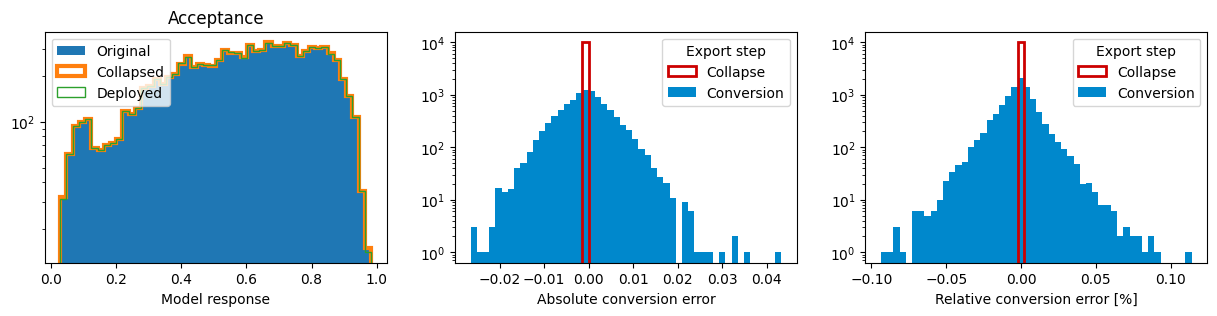

In [17]:
data_reader = FeatherReader(environ.get("ACCEPTANCE_TEST_DATA", "acceptance-validation"))
test_dataset = data_reader.as_dask_dataframe().head(10_000, npartitions=-1)
pX = test_dataset[data_reader.features].values
X = invert_column_transformer(acceptance.tX, pX)

make_comparison_plot(
    "Acceptance",
    acceptance.model.predict(pX, verbose=False),
    acceptance.collapsed_model.predict(pX, verbose=False),
    acceptance.deployed(X)
)

### Validation of the efficiency model

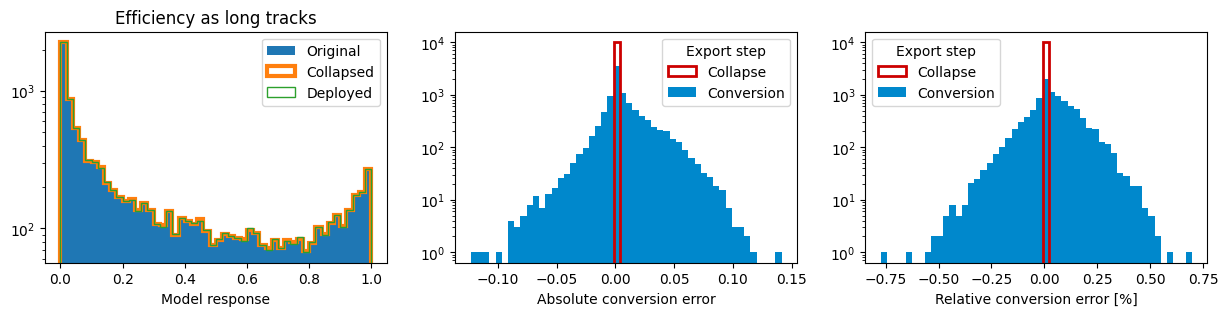

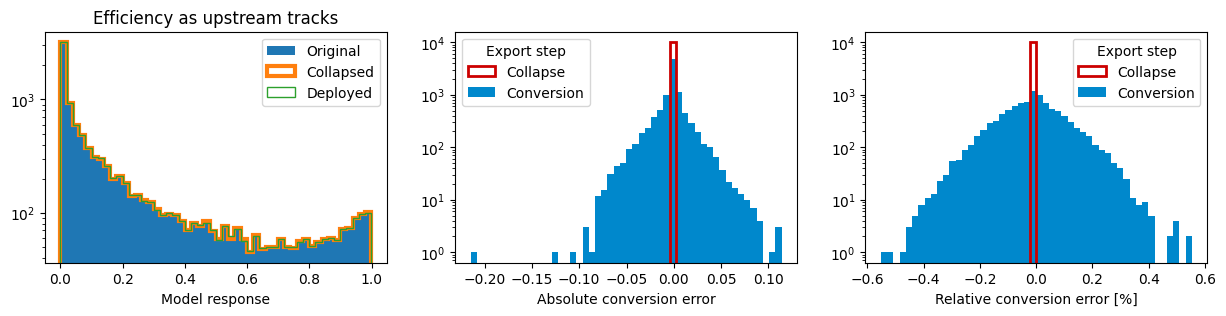

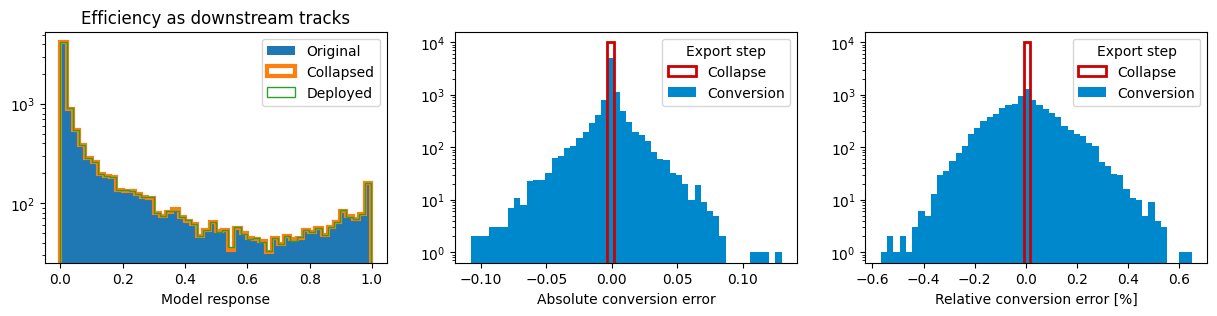

In [18]:
data_reader = FeatherReader(environ.get("EFFICIENCY_TEST_DATA", "efficiency-validation"))
test_dataset = data_reader.as_dask_dataframe().head(10_000, npartitions=-1)
pX = test_dataset[data_reader.features].values
X = invert_column_transformer(efficiency.tX, pX)

make_comparison_plot(
    "Efficiency as long tracks",
    efficiency.model.predict(pX, verbose=False)[:,1],
    efficiency.collapsed_model.predict(pX, verbose=False)[:,1],
    efficiency.deployed(X)[:,1]
)

make_comparison_plot(
    "Efficiency as upstream tracks",
    efficiency.model.predict(pX, verbose=False)[:,2],
    efficiency.collapsed_model.predict(pX, verbose=False)[:,2],
    efficiency.deployed(X)[:,2]
)

make_comparison_plot(
    "Efficiency as downstream tracks",
    efficiency.model.predict(pX, verbose=False)[:,3],
    efficiency.collapsed_model.predict(pX, verbose=False)[:,3],
    efficiency.deployed(X)[:,3]
)

### Validation of the resolution model 

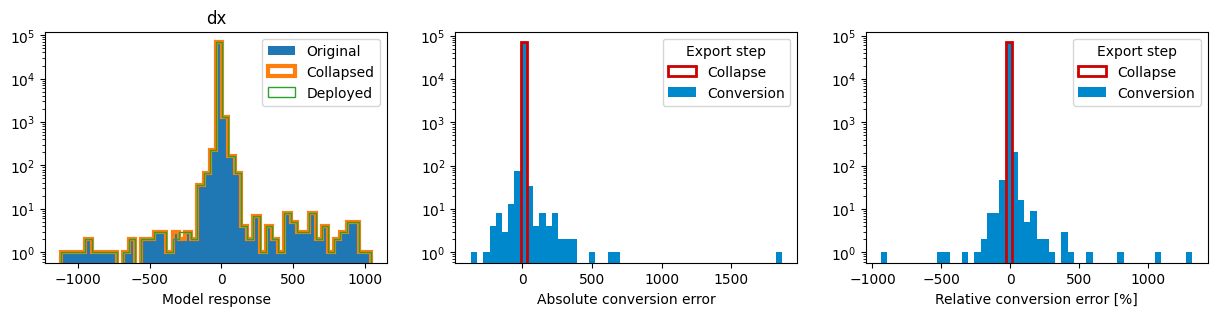

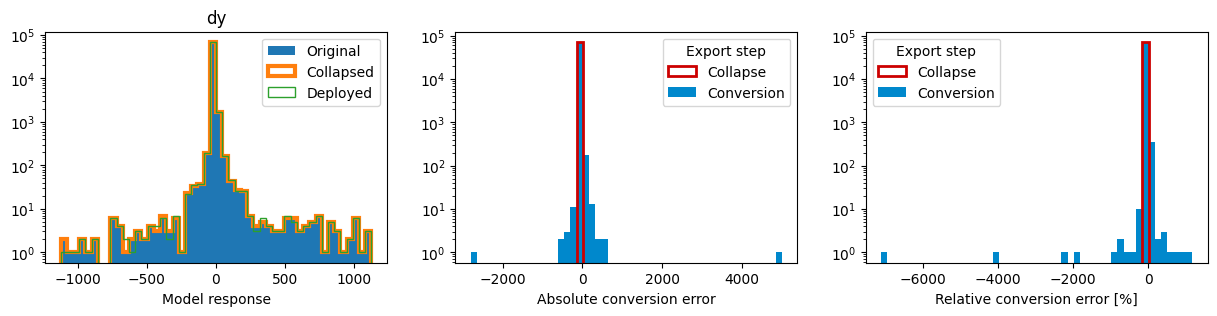

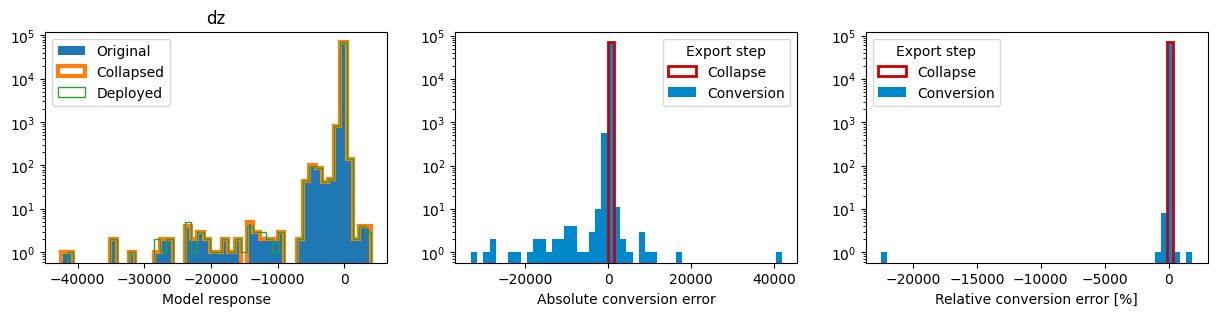

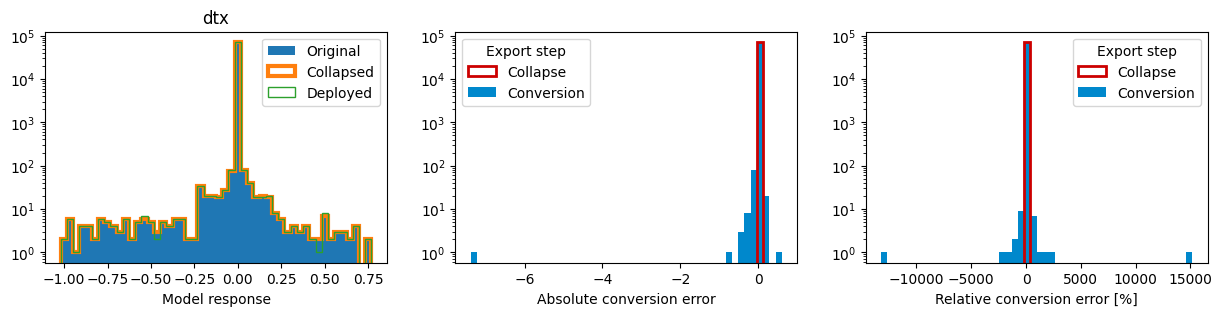

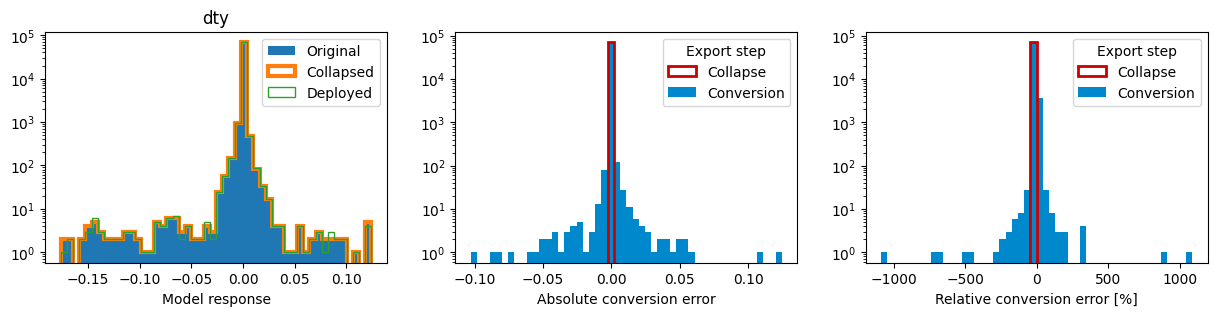

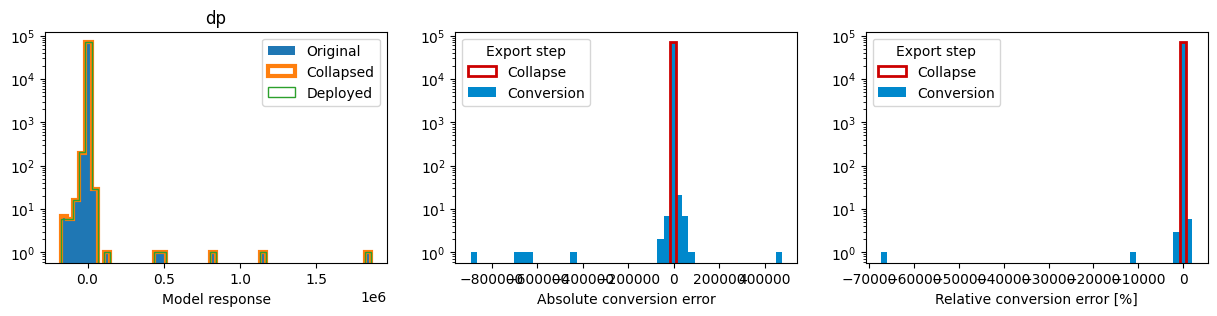

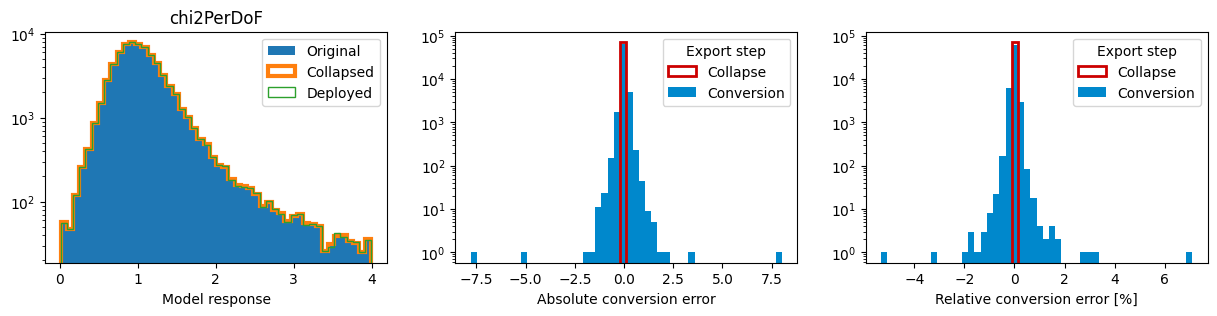

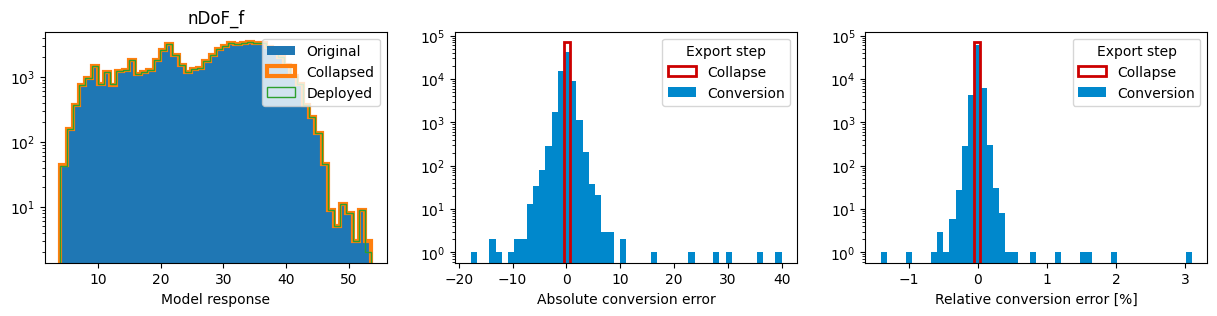

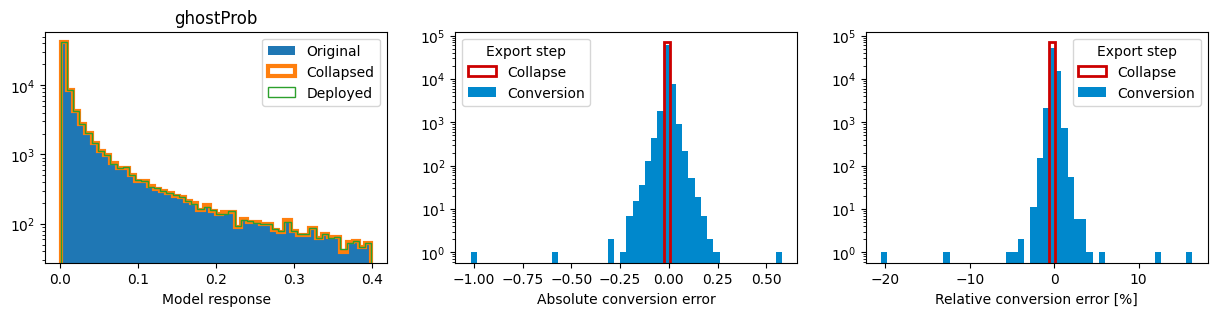

In [19]:
data_reader = FeatherReader(environ.get("RESOLUTION_TEST_DATA", "resolution-validation"))
test_dataset = data_reader.as_dask_dataframe().head(100_000, npartitions=-1)
pX = test_dataset[data_reader.features].values
X = invert_column_transformer(resolution.tX, pX)
r = np.random.normal(0, 1, (len(X), 128))

pY_py = resolution.model.predict((pX, r), batch_size=1000, verbose=False)
Y_py = resolution.tY.inverse_transform(pY_py)
pY_pyc = resolution.collapsed_model.predict(np.concatenate((pX, r), axis=1), batch_size=1000, verbose=False)
Y_pyc = resolution.tY.inverse_transform(pY_pyc)

Y_c = resolution.deployed(X, r)

for iVar, var_name in enumerate(data_reader.labels):
    make_comparison_plot(
        var_name,
        Y_py[:,iVar],
        Y_pyc[:,iVar],
        Y_c[:,iVar]
    )

### Validation of the covariance model

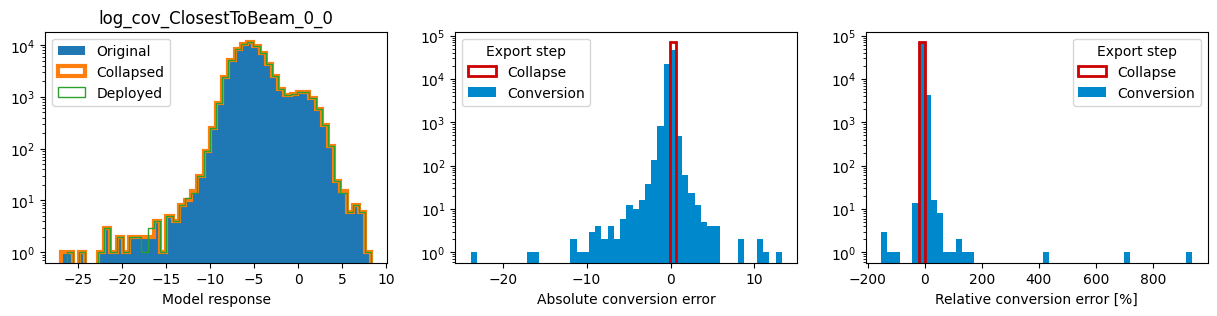

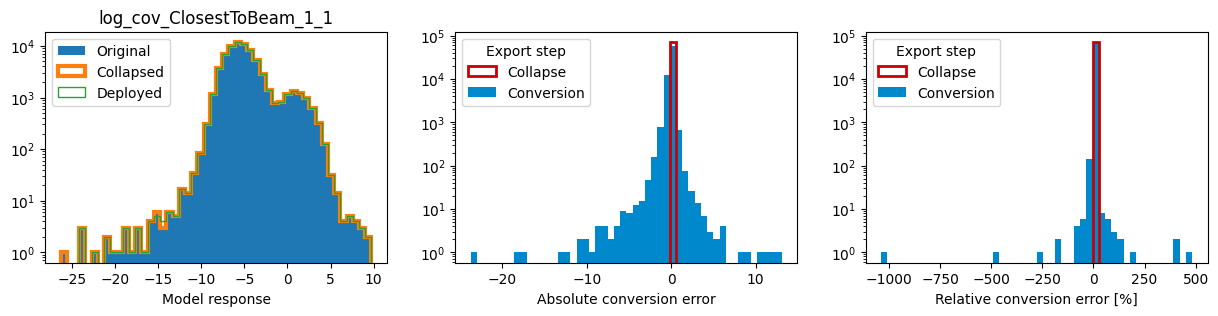

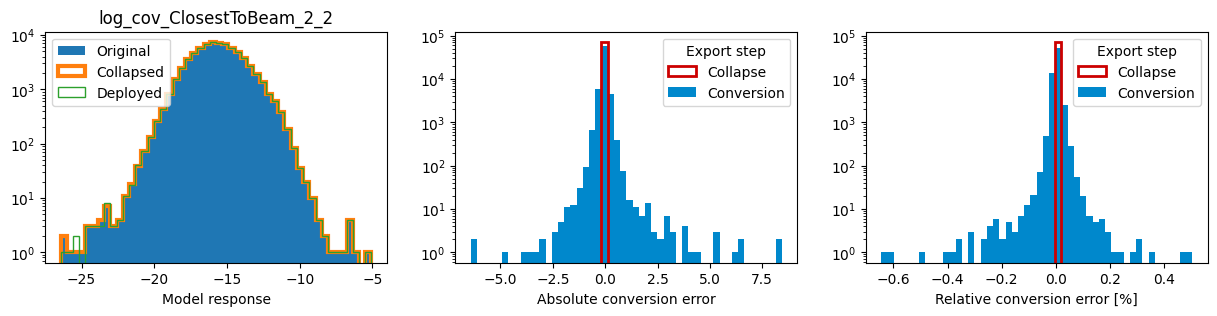

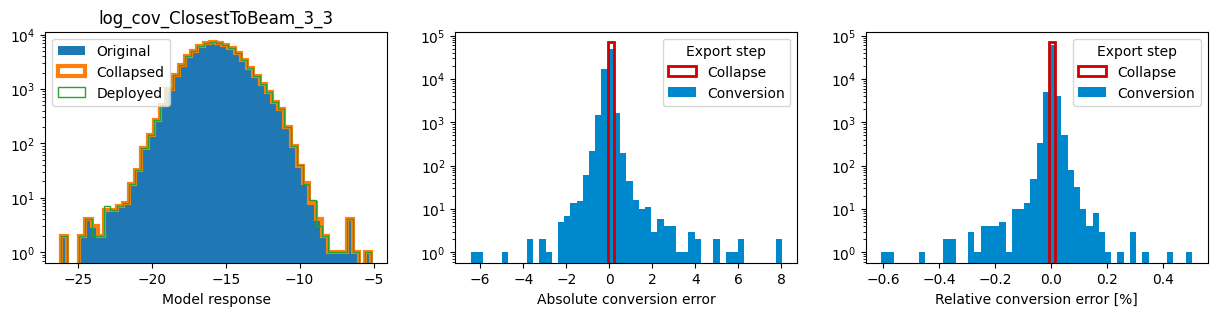

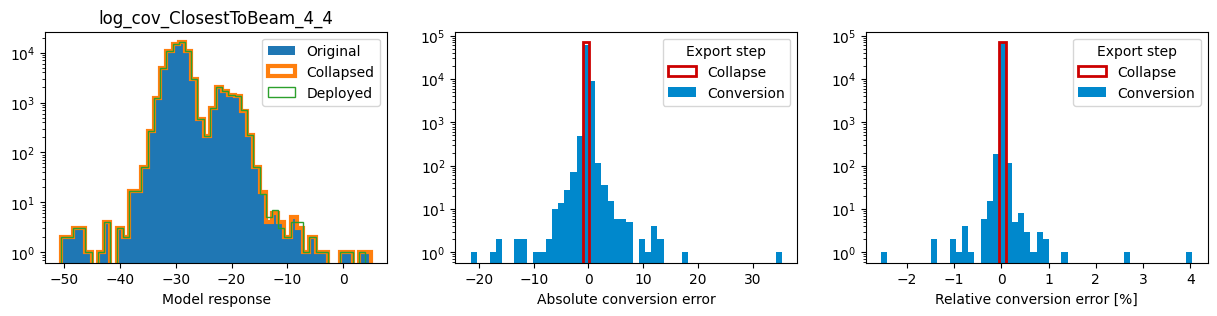

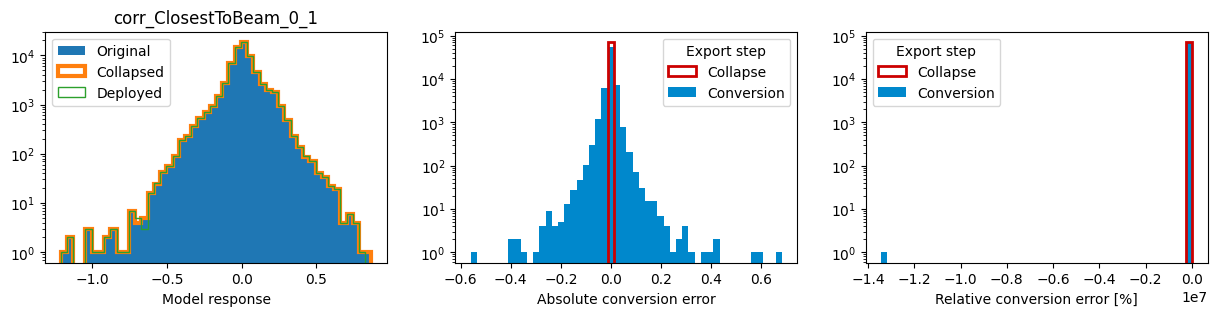

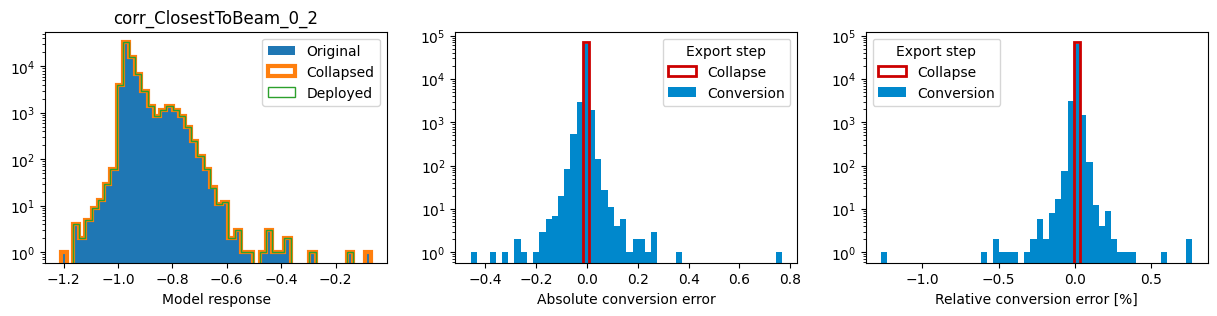

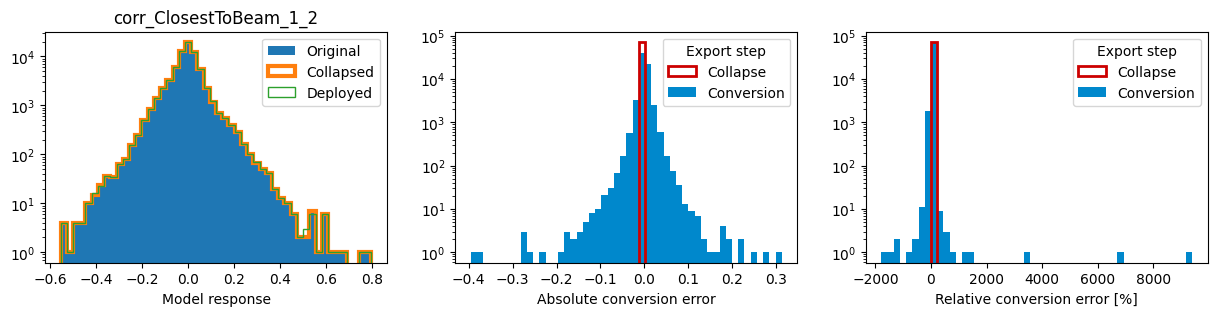

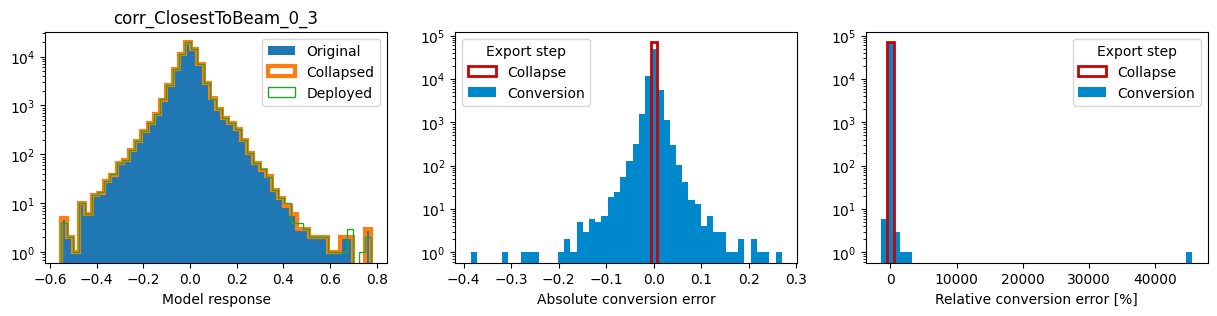

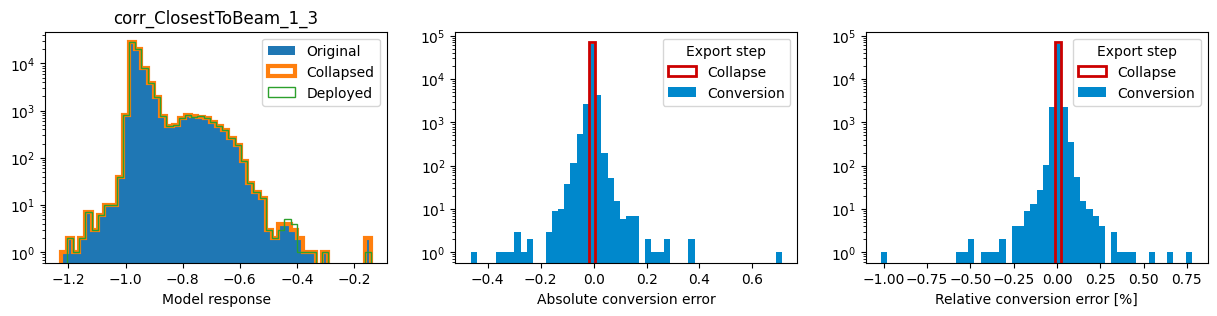

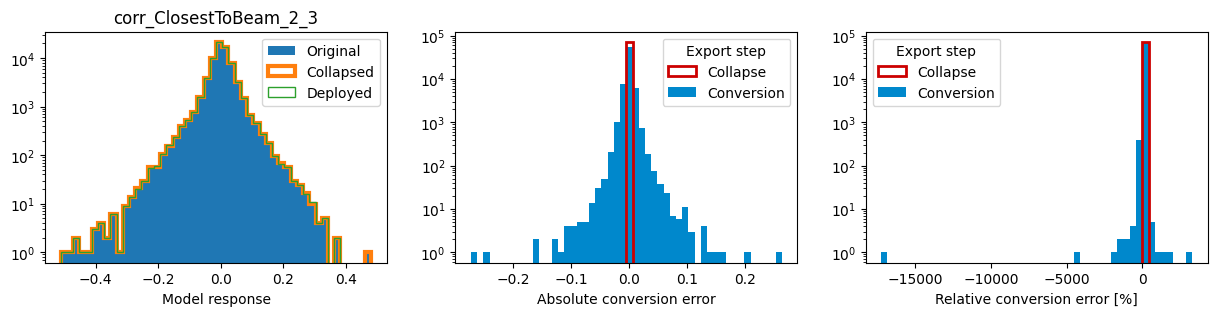

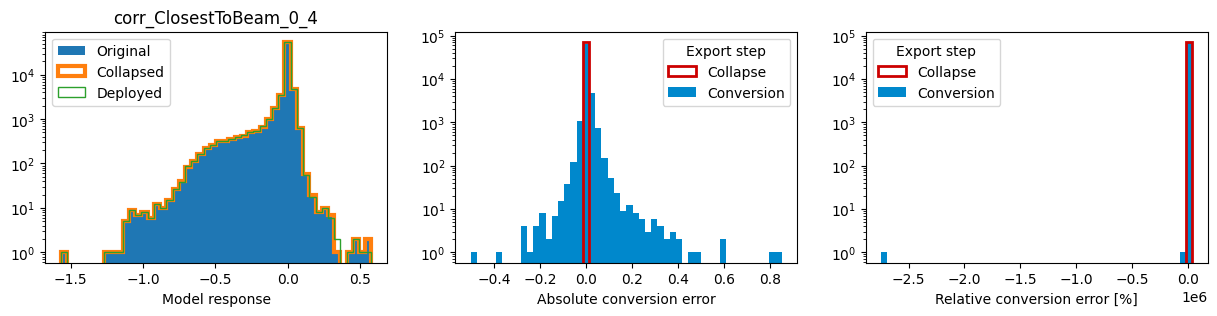

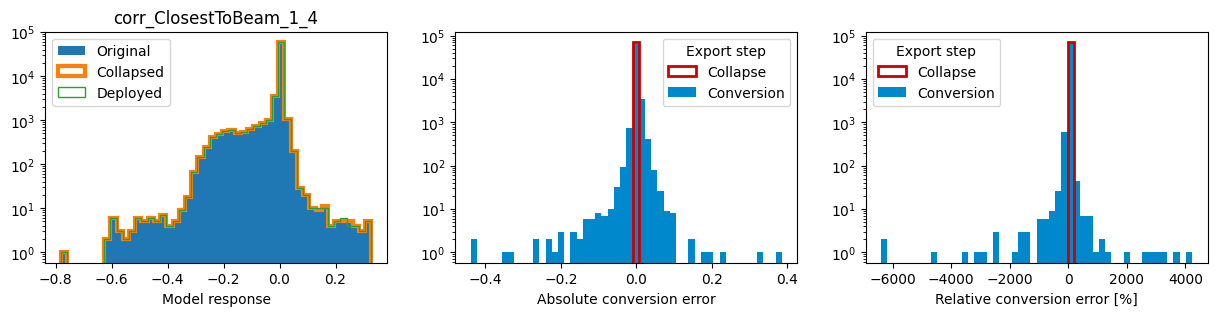

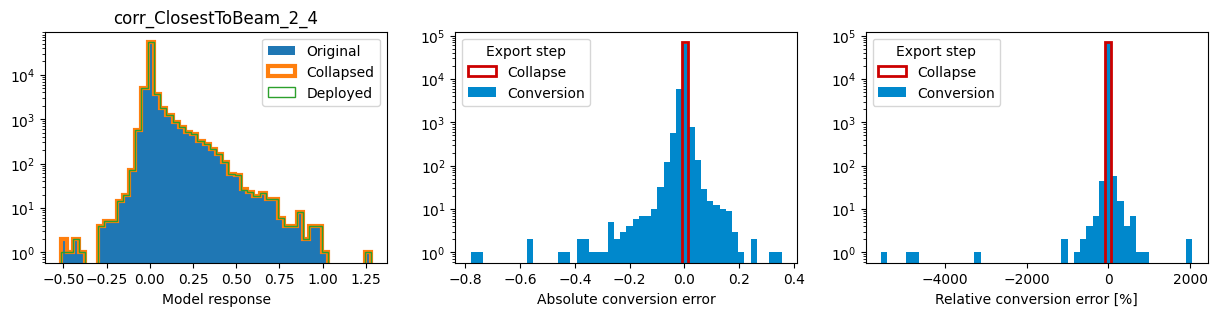

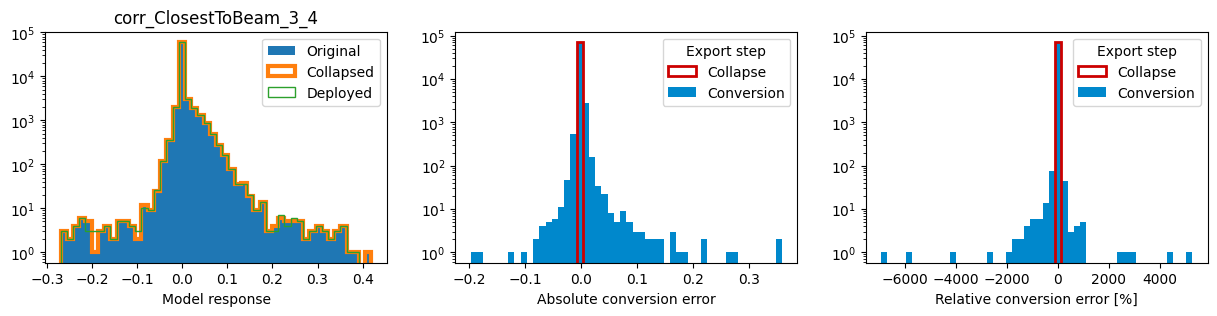

In [20]:
data_reader = FeatherReader(environ.get("COVARIANCE_TEST_DATA", "covariance-validation"))
test_dataset = data_reader.as_dask_dataframe().head(100_000, npartitions=-1)
pX = test_dataset[data_reader.features].values
X = invert_column_transformer(covariance.tX, pX)
r = np.random.normal(0, 1, (len(X), 128))

pY_py = covariance.model.predict((pX, r), batch_size=1000, verbose=False)
Y_py = covariance.tY.inverse_transform(pY_py)
pY_pyc = covariance.collapsed_model.predict(np.concatenate((pX, r), axis=1), batch_size=1000, verbose=False)
Y_pyc = covariance.tY.inverse_transform(pY_pyc)

Y_c = covariance.deployed(X, r)

for iVar, var_name in enumerate(data_reader.labels):
    make_comparison_plot(
        var_name,
        Y_py[:,iVar],
        Y_pyc[:,iVar],
        Y_c[:,iVar]
    )

# Conclusion

In this notebook we discussed the procedure to export the trained models to a shared C library that can be easily 
imported at run time in Gaudi-based applications.

The procedure used involves three steps:
 * collapsing the model from a functional form to a sequential model;
 * generating C code for the steps and completing it with the logic describing the sequence of the steps;
 * compiling the C code into a shared library.
 
Finally, we have validated the procedure by comparing the results obtained running the original, collapsed and exported models on a subset of the training dataset.
Studying the distributions we observe that the conversion introduces a small level of discrepancy between the exported and original data, probably because of floating point algebra or small discrepancies in the implementations of the quantile transformation.

Still, the distributions are very well reproduced and the pathological entries are at the permil level or less, with relative errors of few percents that should not compromise the overall quality of the simulation.

The most worrying case is probably the resolution where in $\mathcal O(10^{-5})$ cases the events are pushed very far from the original value and might end up in unphysical regions. This might require to crop the resolution distribution to avoid outlayers.

Tuning the hyperparameters of the quantile transformers is known to have a significan effect on these discrepancies. However, increasing the number of bins also slows down the evaluation, so that a trade-off between speed and "safety" must be found.

In [ ]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,rename,path,makedirs
    
    nb_save  = f"{environ['HOME_DIR']}/notebooks_exports"         # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']            # according to train data
    #if environ['MODEL_VARIANT'] != '':
    #    nb_save  = nb_save+'/'+environ['MODEL_VARIANT']           # according to model variant
    makedirs(nb_save,exist_ok=True)                               
    
    nbs_path = f"{environ['HOME_DIR']}/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Deploy.ipynb"                                  # notebook name
    extensions  = ["html"]                                  # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))